In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller


In [2]:
# $ python dl.py BTCUSDT 2024-11-01 2024-11-03 market_data binance 5m futures --type=um
# $ python dl.py BTCUSDT 2024-11-01 2024-11-03 market_data binance 5m spot

In [3]:
futures = pd.read_csv('market_data/binance-futures-BTCUSDT-5m.csv', index_col='time')
spot = pd.read_csv('market_data/binance-spot-BTCUSDT-5m.csv', index_col='time')

futures.index = pd.to_datetime(futures.index, unit='ms')
spot.index = pd.to_datetime(spot.index, unit='ms')

In [4]:
futures.head()

,open,high,low,close,volume
time,,,,,
2024-11-01 05:00:00,69618.6,69639.6,69568.3,69636.3,277.169
2024-11-01 05:05:00,69636.4,69662.7,69565.5,69565.6,321.053
2024-11-01 05:10:00,69565.5,69588.5,69549.3,69577.5,250.829
2024-11-01 05:15:00,69577.5,69625.1,69549.3,69622.6,162.219
2024-11-01 05:20:00,69622.6,69666.6,69600.0,69621.3,308.458


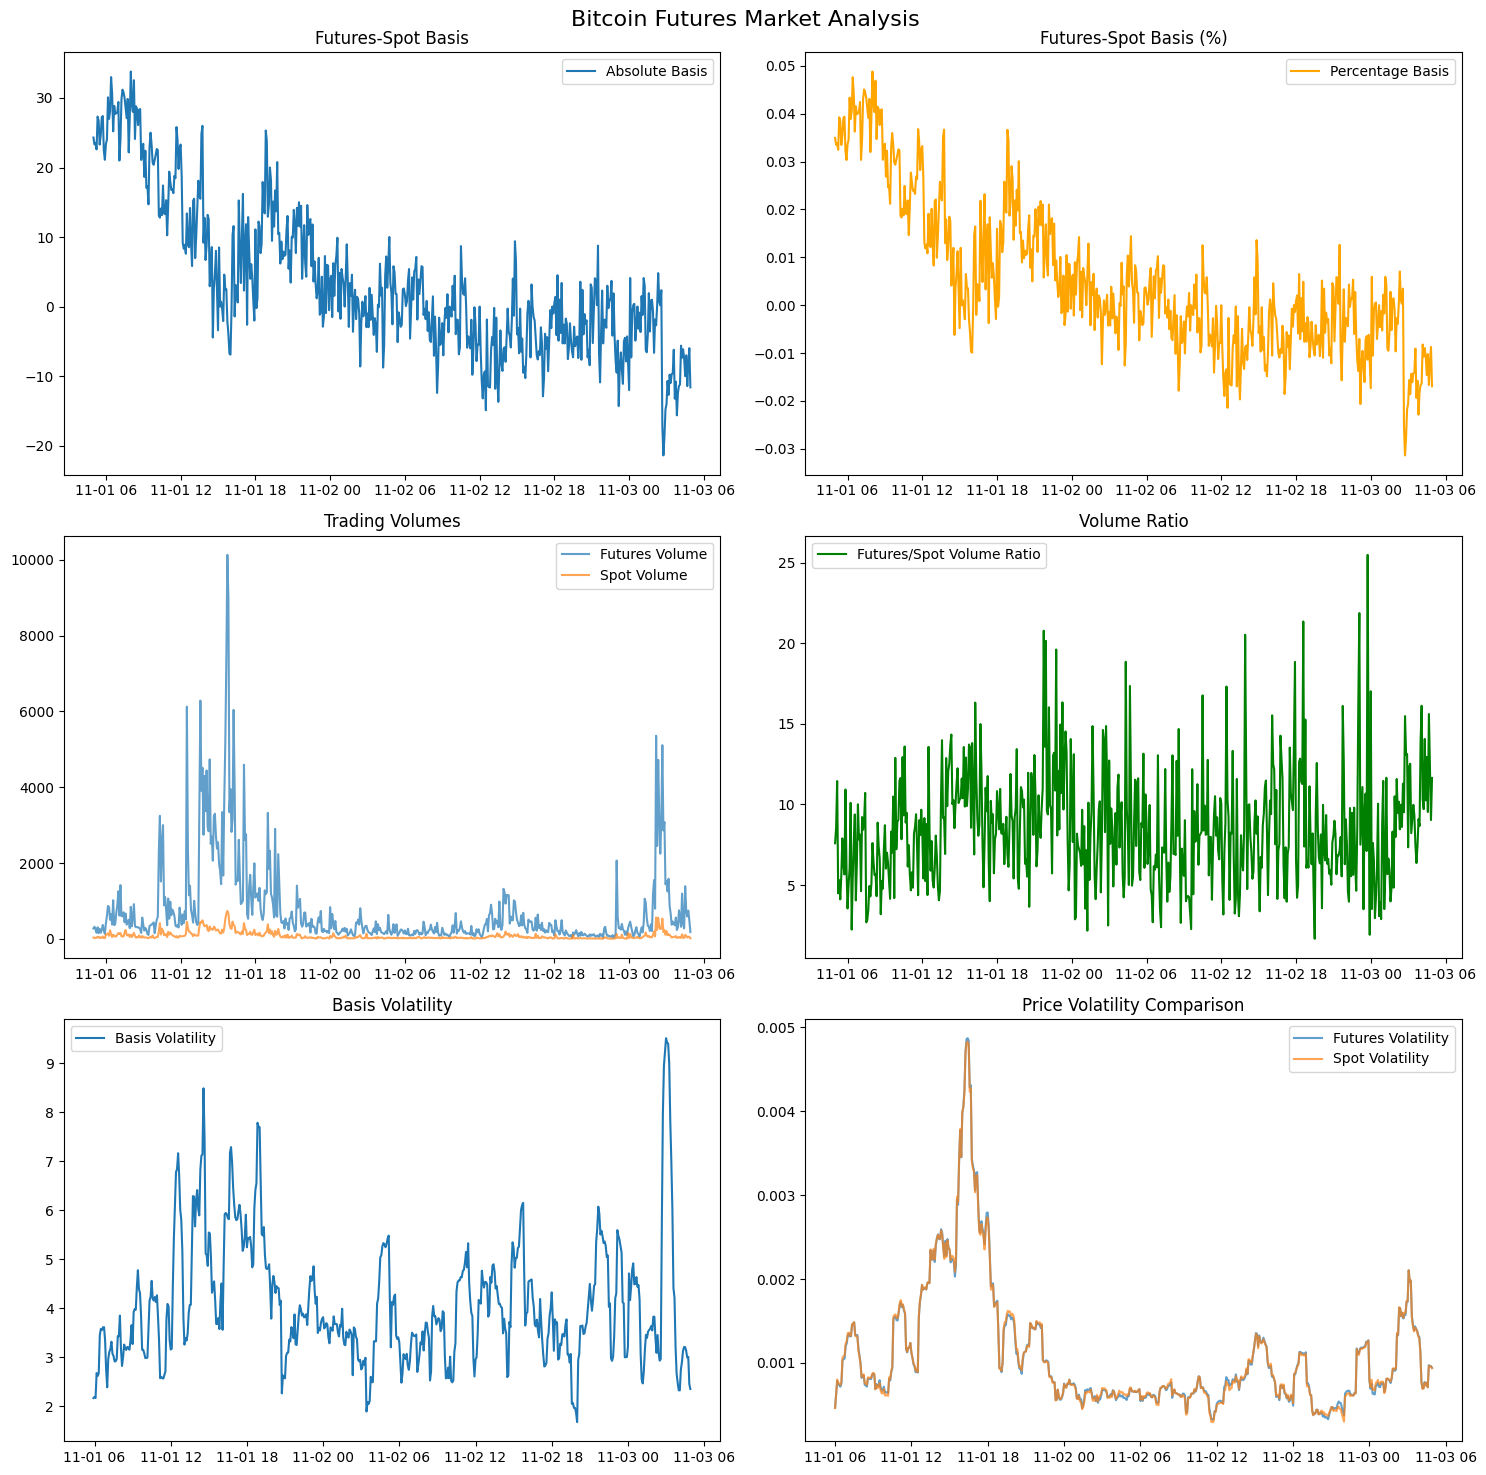


Summary Statistics:
mean_basis: 3.7910
std_basis: 10.9326
max_basis: 33.8000
min_basis: -21.4000
mean_basis_pct: 0.0054
mean_volume_ratio: 8.5514
correlation_volumes: 0.9430
correlation_volatilities: 0.9995


In [6]:
def analyze_futures_market(futures, spot):
    # 1. Calculate basis metrics
    basis = (futures['close'] - spot['close']).rename('basis')
    basis_pct = ((futures['close'] - spot['close']) / spot['close'] * 100).rename('basis_pct')
    
    # 2. Calculate rolling metrics
    rolling_window = 12  # 1-hour window (12 * 5min)
    basis_volatility = basis.rolling(rolling_window).std().rename('basis_volatility')
    basis_pct_volatility = basis_pct.rolling(rolling_window).std().rename('basis_pct_volatility')
    
    # 3. Calculate volume metrics
    futures_volume = futures['volume'].rename('futures_volume')
    spot_volume = spot['volume'].rename('spot_volume')
    volume_ratio = (futures['volume'] / spot['volume']).rename('volume_ratio')
    
    # 4. Calculate price volatility
    futures_returns = np.log(futures['close']).diff()
    spot_returns = np.log(spot['close']).diff()
    futures_volatility = futures_returns.rolling(rolling_window).std().rename('futures_volatility')
    spot_volatility = spot_returns.rolling(rolling_window).std().rename('spot_volatility')
    
    # Combine all metrics
    analysis_df = pd.DataFrame({
        'basis': basis,
        'basis_pct': basis_pct,
        'basis_volatility': basis_volatility,
        'basis_pct_volatility': basis_pct_volatility,
        'futures_volume': futures_volume,
        'spot_volume': spot_volume,
        'volume_ratio': volume_ratio,
        'futures_volatility': futures_volatility,
        'spot_volatility': spot_volatility
    })
    
    # Calculate summary statistics
    summary_stats = {
        'mean_basis': basis.mean(),
        'std_basis': basis.std(),
        'max_basis': basis.max(),
        'min_basis': basis.min(),
        'mean_basis_pct': basis_pct.mean(),
        'mean_volume_ratio': volume_ratio.mean(),
        'correlation_volumes': futures_volume.corr(spot_volume),
        'correlation_volatilities': futures_volatility.corr(spot_volatility)
    }
    
    return analysis_df, summary_stats

def plot_analysis(analysis_df):
    # Create figure with multiple subplots
    fig, axes = plt.subplots(3, 2, figsize=(15, 15))
    fig.suptitle('Bitcoin Futures Market Analysis', fontsize=16)
    
    # 1. Basis and Percentage Basis
    axes[0,0].plot(analysis_df.index, analysis_df['basis'], label='Absolute Basis')
    axes[0,0].set_title('Futures-Spot Basis')
    axes[0,0].legend()
    
    axes[0,1].plot(analysis_df.index, analysis_df['basis_pct'], label='Percentage Basis', color='orange')
    axes[0,1].set_title('Futures-Spot Basis (%)')
    axes[0,1].legend()
    
    # 2. Volume Analysis
    axes[1,0].plot(analysis_df.index, analysis_df['futures_volume'], label='Futures Volume', alpha=0.7)
    axes[1,0].plot(analysis_df.index, analysis_df['spot_volume'], label='Spot Volume', alpha=0.7)
    axes[1,0].set_title('Trading Volumes')
    axes[1,0].legend()
    
    axes[1,1].plot(analysis_df.index, analysis_df['volume_ratio'], label='Futures/Spot Volume Ratio', color='green')
    axes[1,1].set_title('Volume Ratio')
    axes[1,1].legend()
    
    # 3. Volatility Analysis
    axes[2,0].plot(analysis_df.index, analysis_df['basis_volatility'], label='Basis Volatility')
    axes[2,0].set_title('Basis Volatility')
    axes[2,0].legend()
    
    axes[2,1].plot(analysis_df.index, analysis_df['futures_volatility'], label='Futures Volatility', alpha=0.7)
    axes[2,1].plot(analysis_df.index, analysis_df['spot_volatility'], label='Spot Volatility', alpha=0.7)
    axes[2,1].set_title('Price Volatility Comparison')
    axes[2,1].legend()
    
    plt.tight_layout()
    plt.show()

# Modified mean reversion test
def test_mean_reversion(series, lags=1):
    # Drop any NaN values and ensure equal lengths
    series = series.dropna()
    x = series[:-lags].values  # Previous values
    y = series[lags:].values - series[:-lags].values  # Changes
    return stats.linregress(x, y)

# Run analysis
analysis_df, summary_stats = analyze_futures_market(futures, spot)
plot_analysis(analysis_df)

# Print summary statistics
print("\nSummary Statistics:")
for key, value in summary_stats.items():
    print(f"{key}: {value:.4f}")


In [7]:
# Test for basis mean-reversion
mean_reversion_test = test_mean_reversion(analysis_df['basis'])
print("\nBasis Mean Reversion Test:")
print(f"Coefficient: {mean_reversion_test.slope:.4f}")
print(f"P-value: {mean_reversion_test.pvalue:.4f}")

# Additional analysis: Market efficiency metrics
print("\nMarket Efficiency Metrics:")
print(f"Basis Autocorrelation (lag 1): {analysis_df['basis'].autocorr(1):.4f}")
print(f"Basis Half-life: {-np.log(2)/mean_reversion_test.slope:.4f} periods")

# Calculate arbitrage opportunities
basis_threshold = analysis_df['basis_pct'].std() * 2  # 2 standard deviations
arbitrage_opportunities = (analysis_df['basis_pct'].abs() > basis_threshold).mean()
print(f"\nPercentage of potential arbitrage opportunities: {arbitrage_opportunities*100:.2f}%")


Basis Mean Reversion Test:
Coefficient: -0.1105
P-value: 0.0000

Market Efficiency Metrics:
Basis Autocorrelation (lag 1): 0.8907
Basis Half-life: 6.2733 periods

Percentage of potential arbitrage opportunities: 10.42%


- The futures basis has generally been positive (average 3.791) indicating contango market conditions
- The percentage basis averages 0.54%, suggesting relatively efficient markets
- The basis shows clear mean-reversion tendencies, with values ranging from -21.4 to +33.8
- The basis distribution is slightly right-skewed with fat tails, indicating occasional extreme premiums/discounts


### Market Efficiency:


- The tight correlation between spot and futures markets suggests good price efficiency
- The relatively small average basis (0.54%) indicates strong arbitrage activity
- However, occasional large deviations in basis suggest arbitrage opportunities
- The volume ratio stability suggests consistent market depth

> while the futures market is generally efficient, there are regular opportunities from basis trading and the strong mean reversion tendency suggests these opportunities are relatively reliable if properly managed.

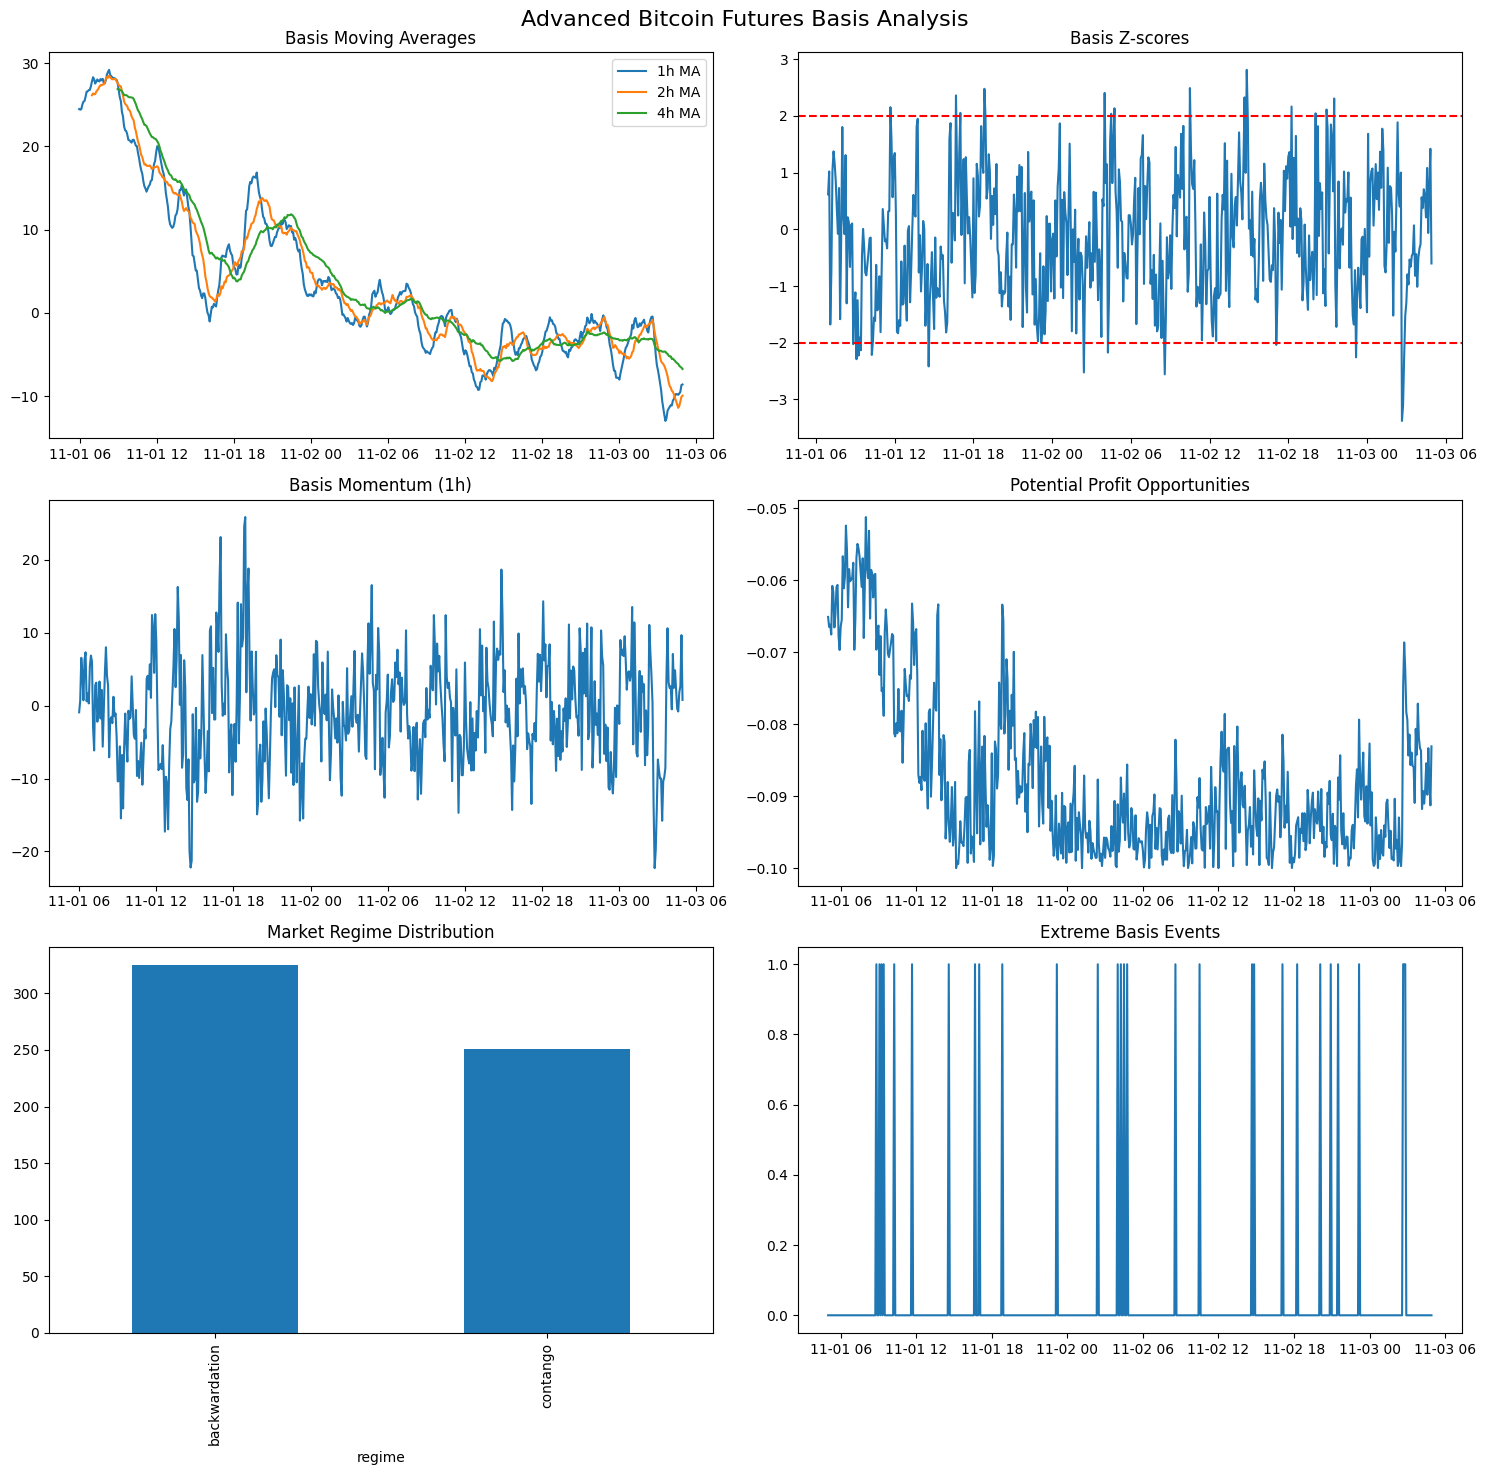


Regime Analysis:
regime_duration:
regime
backwardation    325
contango         251
Name: count, dtype: int64

regime_changes:
177

contango_profit:
-0.08870386155946078

backwardation_profit:
-0.08704251056943949

extreme_events:
extreme_basis
False    547
True      29
Name: count, dtype: int64

extreme_duration:
1.2585895117540686


Trading Signal Statistics:
mean_signal: -0.0978
signal_volatility: 1.0699
signal_skew: 0.1868
signal_autocorr: 0.3598

Predictive Analysis:
Basis mean reversion strength: 0.4377
Average profit opportunity: -0.0878%
Profit opportunity volatility: 0.0113%


In [9]:
def analyze_basis_patterns(futures, spot):
    # Calculate basic basis metrics
    basis = futures['close'] - spot['close']
    basis_pct = (futures['close'] - spot['close']) / spot['close'] * 100
    
    # Calculate returns
    spot_returns = spot['close'].pct_change()
    futures_returns = futures['close'].pct_change()
    
    # Calculate various timeframe basis metrics
    windows = [12, 24, 48]  # 1-hour, 2-hour, 4-hour
    basis_metrics = pd.DataFrame()
    
    for window in windows:
        basis_metrics[f'basis_ma_{window}'] = basis.rolling(window).mean()
        basis_metrics[f'basis_std_{window}'] = basis.rolling(window).std()
        basis_metrics[f'basis_zscore_{window}'] = (basis - basis.rolling(window).mean()) / basis.rolling(window).std()
    
    # Calculate basis momentum
    basis_metrics['basis_momentum'] = basis - basis.shift(12)  # 1-hour momentum
    
    # Calculate basis regime changes
    basis_metrics['regime'] = np.where(basis > basis.rolling(24).mean(), 'contango', 'backwardation')
    
    # Calculate basis CrossOvers
    basis_metrics['basis_ma_crossover'] = np.sign(basis_metrics['basis_ma_12'] - basis_metrics['basis_ma_24']).diff()
    
    # Identify extreme basis events
    zscore_threshold = 2
    basis_metrics['extreme_basis'] = np.abs(basis_metrics['basis_zscore_24']) > zscore_threshold
    
    # Calculate profit opportunities
    basis_metrics['potential_profit'] = np.abs(basis_pct) - 0.1  # Assuming 0.1% transaction cost
    
    return basis_metrics

def analyze_basis_regimes(basis_metrics, basis):
    # Calculate regime statistics
    regime_stats = pd.DataFrame()
    
    # Duration of regimes
    regime_duration = basis_metrics['regime'].value_counts()
    regime_changes = (basis_metrics['regime'] != basis_metrics['regime'].shift(1)).sum()
    
    # Profitability in different regimes
    contango_profit = basis_metrics[basis_metrics['regime'] == 'contango']['potential_profit'].mean()
    backwardation_profit = basis_metrics[basis_metrics['regime'] == 'backwardation']['potential_profit'].mean()
    
    # Extreme events analysis
    extreme_events = basis_metrics['extreme_basis'].value_counts()
    extreme_duration = basis_metrics['extreme_basis'].rolling(24).sum().mean()
    
    return {
        'regime_duration': regime_duration,
        'regime_changes': regime_changes,
        'contango_profit': contango_profit,
        'backwardation_profit': backwardation_profit,
        'extreme_events': extreme_events,
        'extreme_duration': extreme_duration
    }

def plot_basis_analysis(basis_metrics, basis):
    fig, axes = plt.subplots(3, 2, figsize=(15, 15))
    fig.suptitle('Advanced Bitcoin Futures Basis Analysis', fontsize=16)
    
    # Plot 1: Basis Moving Averages
    axes[0,0].plot(basis_metrics['basis_ma_12'], label='1h MA')
    axes[0,0].plot(basis_metrics['basis_ma_24'], label='2h MA')
    axes[0,0].plot(basis_metrics['basis_ma_48'], label='4h MA')
    axes[0,0].set_title('Basis Moving Averages')
    axes[0,0].legend()
    
    # Plot 2: Basis Z-scores
    axes[0,1].plot(basis_metrics['basis_zscore_24'], label='2h Z-score')
    axes[0,1].axhline(y=2, color='r', linestyle='--')
    axes[0,1].axhline(y=-2, color='r', linestyle='--')
    axes[0,1].set_title('Basis Z-scores')
    
    # Plot 3: Basis Momentum
    axes[1,0].plot(basis_metrics['basis_momentum'])
    axes[1,0].set_title('Basis Momentum (1h)')
    
    # Plot 4: Potential Profit Opportunities
    axes[1,1].plot(basis_metrics['potential_profit'])
    axes[1,1].set_title('Potential Profit Opportunities')
    
    # Plot 5: Regime Distribution
    basis_metrics['regime'].value_counts().plot(kind='bar', ax=axes[2,0])
    axes[2,0].set_title('Market Regime Distribution')
    
    # Plot 6: Extreme Events
    axes[2,1].plot(basis_metrics['extreme_basis'])
    axes[2,1].set_title('Extreme Basis Events')
    
    plt.tight_layout()
    plt.show()

def calculate_trading_signals(basis_metrics):
    signals = pd.DataFrame(index=basis_metrics.index)
    
    # Generate trading signals
    signals['ma_cross_signal'] = np.sign(basis_metrics['basis_ma_crossover'])
    signals['zscore_signal'] = np.where(basis_metrics['basis_zscore_24'] < -2, 1, 
                                      np.where(basis_metrics['basis_zscore_24'] > 2, -1, 0))
    signals['momentum_signal'] = np.sign(basis_metrics['basis_momentum'])
    
    # Combine signals
    signals['combined_signal'] = (signals['ma_cross_signal'] + 
                                signals['zscore_signal'] + 
                                signals['momentum_signal'])
    
    # Calculate signal statistics
    signal_stats = {
        'mean_signal': signals['combined_signal'].mean(),
        'signal_volatility': signals['combined_signal'].std(),
        'signal_skew': signals['combined_signal'].skew(),
        'signal_autocorr': signals['combined_signal'].autocorr()
    }
    
    return signals, signal_stats

# Run analysis
basis_metrics = analyze_basis_patterns(futures, spot)
regime_analysis = analyze_basis_regimes(basis_metrics, futures['close'] - spot['close'])
signals, signal_stats = calculate_trading_signals(basis_metrics)

# Plot results
plot_basis_analysis(basis_metrics, futures['close'] - spot['close'])

# Print analysis results
print("\nRegime Analysis:")
for key, value in regime_analysis.items():
    print(f"{key}:")
    print(value)
    print()

print("\nTrading Signal Statistics:")
for key, value in signal_stats.items():
    print(f"{key}: {value:.4f}")

# Calculate predictive metrics
print("\nPredictive Analysis:")
print(f"Basis mean reversion strength: {basis_metrics['basis_zscore_24'].autocorr():.4f}")
print(f"Average profit opportunity: {basis_metrics['potential_profit'].mean():.4f}%")
print(f"Profit opportunity volatility: {basis_metrics['potential_profit'].std():.4f}%")

## Moving Average Analysis

- **Basis**:
  - Shows a clear downward trend from ~30 to -10 over the period.
- **Shorter-term MAs (1h)**:
  - Show more volatility than longer-term (4h).
- **Multiple MA crossovers**:
  - Indicate trading opportunities.
- **Recent trend**:
  - Shows basis becoming more negative.

## Z-score Analysis

- **Extreme moves**:
  - Many instances where basis moves beyond ±2 standard deviations.
- **Mean reversion opportunities**:
  - Extreme events (>2 SD) provide opportunities.
- **Cyclical pattern**:
  - Z-scores show predictable reversion cycles.
- **Trading signals**:
  - Triggered at ±2 SD lines (red dashed lines).

## Basis Momentum

- **Volatility**:
  - High momentum volatility between +20 and -20.
- **Trend confirmation**:
  - Momentum spikes often precede significant basis changes.
- **Oscillation patterns**:
  - Shows regular and predictable oscillations.

## Profit Opportunities

- **Potential profits**:
  - Range from -0.05% to -0.10% after costs.
- **Extreme events**:
  - Higher profit potential during extreme basis events.
- **Recent trends**:
  - Increase in profit opportunities towards the end of the period.
- **Costs**:
  - Transaction costs (assumed 0.1%) need to be factored in.

## Market Regime Analysis

- **Regime balance**:
  - More periods of backwardation than contango.
- **Regime changes**:
  - Clear shifts that can be traded.
- **Regime distribution**:
  - ~320 backwardation vs ~250 contango periods.
- **Signals**:
  - Regime changes signal trading opportunities.

## Trading Strategy Implications

1. **Mean reversion trades**:
   - Take trades when Z-score exceeds ±2.
2. **Trend trades**:
   - Use momentum confirmation.
3. **Regime changes**:
   - Wait for MA crossovers to confirm.
4. **Extreme events**:
   - Monitor for basis opportunities.
5. **Cost management**:
   - Consider costs when evaluating profitability.
6. **Regime shifts**:
   - Use shifts for position sizing.

---

The data suggests a market that regularly presents basis trading opportunities, particularly during extreme events, but requires careful cost management and timing to be profitable.
